In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import tensorflow.keras as keras
from IPython import display
from tensorflow.keras.applications import vgg19
import os
import sys
import time
mpl.rcParams['figure.figsize'] =(10, 10)
mpl.rc('axes.spines',top=False,bottom=False,left=False,right=False)

In [6]:
def load_url_image(url, target_size=None, fname=None):
    if not fname:
        fname = url.split('/')[-1]
    img_path = keras.utils.get_file(os.path.join(os.getcwd(), 'images', fname), url)
    byte_img = tf.io.read_file(img_path)
    img = tf.image.decode_image(byte_img)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    if target_size:
        img = tf.image.resize(img, target_size)
    return img

In [7]:
def load_image(file, target_size=None):
    byte_img = tf.io.read_file(file)
    img = tf.image.decode_image(byte_img)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    if target_size:
        img = tf.image.resize(img, target_size)
    return img

In [8]:
def show_images(images):
        plt.subplot(1, 2, 1)
        plt.imshow(images[0].numpy())
        plt.title('Content Image')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(images[1].numpy())
        plt.title('Style Image')
        plt.axis('off')
        plt.show()

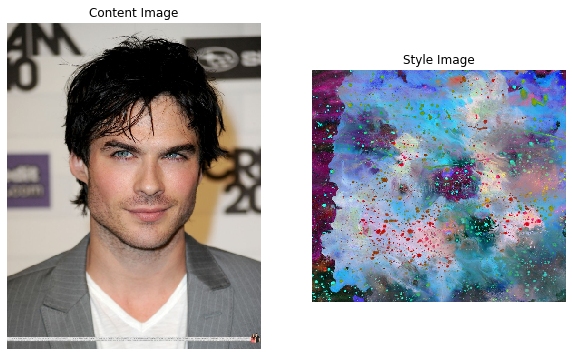

In [93]:
target_size=(360, 280)
content_image = load_url_image('https://i.pinimg.com/originals/b9/bd/14/b9bd14bbe606387d8bc1599936144fcd.jpg', target_size)
style_image = load_image('images/image_3.jpg')
show_images([content_image, style_image])

In [12]:
# If the preprocessing is done outsode the model created
def depreprocess(image):
    img = image.copy()
    if len(img)==1:
        img = tf.squeeze(img, axis=0)
    assert img.shape == 3
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = tf.clip_by_value(img, 0., 1)
    return img

In [55]:
def tensor_to_image(tensor):
    if len(tensor.shape)==4:
        tensor = tf.squeeze(tensor, axis=0)
    image = keras.preprocessing.image.array_to_img(tensor.numpy())
    return image

In [16]:
vgg_model = vgg19.VGG19(weights='imagenet', pooling='avg', include_top=False)
vgg_model.trainable = False
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [17]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
n_content_layers = len(content_layers)
n_style_layers = len(style_layers)

In [18]:
class MyModel(keras.Model):
    def __init__(self, content_layers, style_layers, model):
        super(MyModel, self).__init__()
        self.Content_Layers = content_layers
        self.StyleLayers = style_layers
        self.n_content = len(content_layers)
        self.n_styles = len(style_layers)
        self.inputs = model.inputs
        self.outputs = [model.get_layer(layer).output for layer in (content_layers + style_layers)]
        self.model = keras.models.Model(self.inputs, self.outputs)
        self.model.trainable = False
    
    def call(self, inputs):
        inputs = vgg19.preprocess_input(inputs[tf.newaxis, ...]*255.)
        outs = self.model(inputs)
        contents = outs[:self.n_content]
        styles = outs[self.n_content:]
        return (contents, styles)

In [65]:
model = MyModel(content_layers, style_layers, vgg_model)

In [80]:
contents_target, content_style = model(content_image)
style_content, styles_target = model(style_image)

In [21]:
def content_loss(gen_out, content_target):
    assert gen_out.shape == content_target.shape
    con_loss = tf.reduce_mean((gen_out - content_target)**2, axis=None) 
    return con_loss

In [84]:
def gram_matrix(matrix):
    # Extracting i and j, here the shape is of len 4 which includes batch_size
    if len(matrix.shape)==4:
        matrix = tf.squeeze(matrix, axis=0)
        h, w = matrix.shape[:2]
    matrix = tf.reshape(matrix, [-1, matrix.shape[-1]])
    g_matrix = tf.matmul(matrix, matrix, transpose_a=True)
    return g_matrix/(h*w)

In [23]:
def style_loss(gen_style, style):
    assert gen_style.shape[-1] == style.shape[-1]
    gen_gram = gram_matrix(gen_style)
    style_gram = gram_matrix(style)
    style_loss = tf.reduce_mean((gen_gram - style_gram)**2, axis=None)
    return style_loss

In [58]:
def total_loss(gen_act, alpha=1e04, beta=1e-02):
    gen_contents = gen_act[0]
    gen_styles = gen_act[1]
    n_c = len(gen_contents)
    n_s = len(gen_styles)
    c_loss = 0
    s_loss = 0
    for i in range(n_content_layers):
        c_loss += content_loss(gen_contents[i], contents_target[i])
    for i in range(n_style_layers):
        s_loss += style_loss(gen_styles[i], styles_target[i])
    total_c_loss = alpha * c_loss / n_c
    total_s_loss = beta * s_loss / n_s
    return total_c_loss + total_s_loss, total_c_loss, total_s_loss

In [25]:
optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
variation_weight = 30.

In [26]:
def train_step(image):
    x = tf.identity(image)
    with tf.GradientTape() as tape:
        tape.watch(image)
        out = model(image)
        t_loss, tc_loss, ts_loss = total_loss(out)
        t_loss += variation_weight * tf.image.total_variation(image)
    gradients = tape.gradient(t_loss, image)
    ap = optimizer.apply_gradients([(gradients, image)])
    image.assign(tf.clip_by_value(image, 0.0, 1.0))
    return t_loss, tc_loss, ts_loss

In [27]:
def train(img, epochs=10, steps_per_epoch=100):
    start = time.time()
    step = 0
    for i in range(epochs):
        for j in range(steps_per_epoch):           
            losses, c_losses, s_losses = train_step(img)
            step += 1          
            p = int(((j+1)/steps_per_epoch)*100)
            prog = '='*int(p*0.5)
            dots = '.'*(50 - int(p*0.5))
            sys.stdout.write('\rIteration:{}/{} {}%||[{}{}]- Total_Loss:{:.4f} | Content_Loss:{:.4f} | Style_Loss:{:.4f}'.format(i+1, 
                                                    epochs, p, prog, dots, losses, c_losses, s_losses))
        display.clear_output(wait=True)
        display.display(tensor_to_image(img))
        print('Epoch = {}'.format(i + 1))
        print('Step = {}'.format(step))
    end = time.time()
    print("Total Time Taken = {} minutes".format(round((end - start)/60), 2))
    return img

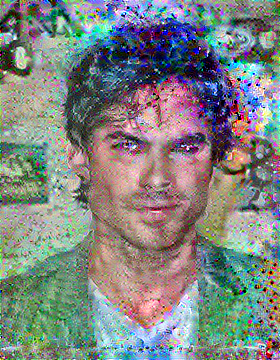

Epoch = 5
Step = 500
Total Time Taken = 41 minutes


In [83]:
generated_image = train(tf.Variable(content_image), epochs = 5)

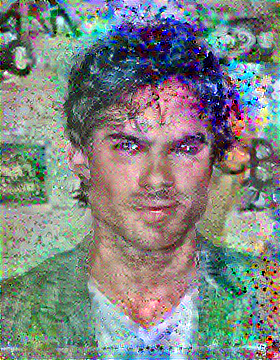

Epoch = 5
Step = 500
Total Time Taken = 40 minutes


In [85]:
generated_image = train(tf.Variable(content_image), epochs = 5)

In [90]:
gen = tensor_to_image(generated_image)
gen.save('images/new_image.jpg')

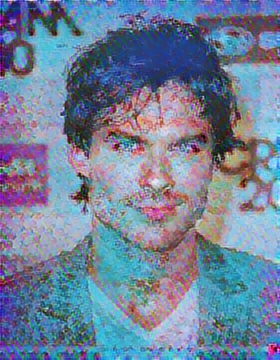

In [88]:
# Using Pretrained Model
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image[tf.newaxis,...]), tf.constant(style_image[tf.newaxis,...]))[0]
tensor_to_image(stylized_image)